<a href="https://colab.research.google.com/github/jordankando/brillouinfitting/blob/main/6_Burnman3_Elasticity_exercise_corrected.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Run this to install packages if in Colab!

In [20]:
#!pip install burnman==1.2.0 numpy==1.24.4
#!pip install --force-reinstall numpy==1.24.4

In [21]:
# import burnman packages, particularly the anisotropy module.
import burnman
from burnman.classes import anisotropy

In [22]:
# first import necessary modules
from __future__ import print_function

import os
import sys
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [23]:
# import the module for matrix rotation

from pyquaternion import Quaternion

In [24]:
# define the styles for the plot
try:
    plt.style.use('ggplot')
    plt.rcParams['axes.facecolor'] = 'white'
    plt.rcParams['axes.edgecolor'] = 'black'
    plt.rcParams['figure.figsize'] = 16, 10 # inches
except:
    pass

# Project  Portion:


## Main Project Functions

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np


import burnman.utils.unitcell
import scipy.optimize


See https://orix.readthedocs.io/en/stable/tutorials/crystal_reference_frame.html for reference for below calculation.


In [26]:
# TODO: Convert Miller indices to cartesian vector, and vice versa
# recall Miller Index to Cartesian Coordinate is equal to the inversion of the
# (h k l) = (1/x , 1/y, 1/z) ; (1 0 0) is (1, inf, inf); (2 1 0) is (1/2, 1, inf)
def convert_miller_to_cartesian(hkl, unit_cell_params):
  A = burnman.utils.unitcell.cell_parameters_to_vectors(unit_cell_params)
  xyz = hkl @ np.linalg.inv(A).T
  return xyz

def convert_cartesian_to_miller(xyz, unit_cell_params):
  [a, b, c, alpha, beta, gamma] = unit_cell_params
  A = burnman.utils.unitcell.cell_parameters_to_vectors(unit_cell_params)

  hkl = xyz @ np.linalg.inv(np.linalg.inv(A).T)
  return hkl



In [27]:
def compute_anisotropic_params(mineral,
                            angles = None,
                            plane_normal = None,
                            direction = None,
                            offset = 0,
                            angle_range = None,
                            angle_count = None,):
  
  if angles is None:
    angles = np.linspace(offset, offset+angle_range, angle_count)



  direction_prime = []
  angle = []

  for a in angles:
    q = Quaternion(axis = plane_normal, degrees = a)
    d_prime = q.rotate(direction)
    direction_prime.append(d_prime)
    angle.append(q.degrees)

  vps = []
  vs1s = []
  vs2s = []
  betas = []
  Es = []
  #incident_angle = np.empty_like(direction_prime)

  for i, d in enumerate(direction_prime):
      velocities = mineral.wave_velocities(d)
      betas.append(mineral.isentropic_linear_compressibility(d))
      Es.append(mineral.isentropic_youngs_modulus(d))
      vps.append(velocities[0][0])
      vs1s.append(velocities[0][1])
      vs2s.append(velocities[0][2])

  return (vps, vs1s, vs2s, betas, Es)

In [28]:
# Same as above, but velocities only
def compute_anisotropic_vel(mineral,
                            angles = None,
                            plane_normal = None,
                            direction = None,
                            offset = 0,
                            angle_range = None,
                            angle_count = None,):
  
  if angles is None:
    angles = np.linspace(offset, offset+angle_range, angle_count)

  direction_prime = []
  angle = []

  for a in angles:
    q = Quaternion(axis = plane_normal, degrees = a)
    d_prime = q.rotate(direction)
    direction_prime.append(d_prime)
    angle.append(q.degrees)

  vps = []
  vs1s = []
  vs2s = []
  betas = []
  Es = []
  #incident_angle = np.empty_like(direction_prime)

  for i, d in enumerate(direction_prime):
      
      velocities = mineral.wave_velocities(d)
      vps.append(velocities[0][0])
      vs1s.append(velocities[0][1])
      vs2s.append(velocities[0][2])

  return (vps, vs1s, vs2s)

In [29]:
def fit_Cij_lsq_old(xs,
            ys,
            theta_0,
            mineral_type,
            rho,
            hkl_norm,
            unit_cell_params):

  """Primary least squares fitting function:

  Args:

  xs: (1xn) Measurement angles in degrees (nd.array)
  ys: (3xn) M output parameters (vp, vs1, vs2)  (nd.array):
  theta0: Initial guesses on Cijs, offset angle
  mineral_type: Mineral defining function from burnman (default: burnman.anisotropy.CubicMaterial)
  rho: density in units?
  hkl_norm: Miller indices of plane normal
  unit_cell_params: a, b, c, alpha, beta, gamma that define a particular unit cell
  """

  ys_flat = np.array(ys)
  ys_flat = ys.flatten()

  # Convert plane hkl to Cartesian vector of plane normal
  plane_normal = convert_miller_to_cartesian(hkl=hkl_norm,
                                             unit_cell_params = unit_cell_params)

  # Determine starting vector orthogonal to plane normal

  # Handle edge case where if starting vector is [0,0,1],
  # then would return [0,0,0] as vector
  if plane_normal[0] == 0.0 and plane_normal[1] == 0.0:
        direction = [1,0,0]
  else:
        direction = np.array([-plane_normal[1], plane_normal[0], 0])
        direction = direction / np.linalg.norm(direction) # Normalize dir vector

  #Determine angle range to compute over
  angle_range = np.max(xs) - np.min(xs)
  angle_count = xs.size

  #Define objective function for least squares optimization
  def obj_fun(params,
               ys = ys_flat,
               mineral_type = mineral_type,
               angle_range = angle_range,
               angle_count = angle_count,
               direction = direction,
               plane_normal = plane_normal):

    #All non-offset parameters are some number of Cij
    offset = params[-1]
    Cijs = params[:-1]

    #Define mineral using burnman.anisotropy mineral class for given Cijs
    mineral = mineral_type(rho, Cijs)

    #Compute anisotropic parameters
    (vps, vs1s, vs2s) = compute_anisotropic_vel(mineral = mineral,
                                                angle_range = angle_range,
                                                angle_count = angle_count, #due to included endpoints
                                                plane_normal = plane_normal,
                                                direction = direction,
                                                offset = offset)
    #Consolidate multiple properties of material
    ymodel = np.array(vps + vs1s + vs2s)

    #Return differnce between modeled and observed properties
    return ymodel - ys

  # No bounds on Cij
  low_bound = np.ones_like(theta_0[:-1]) * -np.inf
  high_bound = -low_bound

  # Offset bound between -180 and 180 deg for symmetry
  low_bound = low_bound.tolist() + [-180.]
  high_bound = high_bound.tolist() + [180.]


  # Use sci-py to perform simple non-linear least squares fitting
  result = scipy.optimize.least_squares(fun = obj_fun,
                                          x0 = theta_0,
                                          bounds = (low_bound, high_bound),
                                          verbose = 1,
                                          max_nfev=1e15,
                                          ftol = 1e-15)
  
  J = result.jac

  cov = np.linalg.inv(J.T@J)

  print(result.x)

  # Compute full curve for best fit model
  min_model = mineral_type(rho, result.x[:-1])
  best_fit_model = compute_anisotropic_vel(mineral = min_model,
                                          angle_range = 360,
                                          angle_count = 360,
                                          plane_normal = plane_normal,
                                          direction = direction,
                                          offset = result.x[-1])

  plt.figure()

  return result.x, np.sqrt(np.diagonal(cov))

In [52]:
def fit_Cij_lsq(x_vps,
            vps,
            x_vs1s,
            vs1s,
            x_vs2s, 
            vs2s,
            theta_0,
            mineral_type,
            rho,
            xyz_norm = None,
            hkl_norm = None,
            unit_cell_params = None):
  """_summary_

  Args:
      x_vps (np.ndarray): _description_
      vps (np.ndarray): _description_
      x_vs1s (np.ndarray): _description_
      vs1s (np.ndarray): _description_
      x_vs2s (np.ndarray): _description_
      vs2s (np.ndarray): _description_
      theta_0 (np.ndarray): _description_
      mineral_type (_type_): _description_
      rho (_type_): _description_
      xyz_norm (np.ndarray): nx3 array, where each row is a different xyz. Defaults to None.
      hkl_norm (list of np.ndarray or np.ndarray, optional): _description_. Defaults to None.
      unit_cell_params (_type_, optional): _description_. Defaults to None.

  Returns:
      _type_: _description_
  """

  if xyz_norm is None and hkl_norm is None:
      print("Please specify start direction in either cartesian coordinates (xyz_norm=) or Miller indices (hkl_norm)")
      return -1

  if hkl_norm is not None and unit_cell_params is None:
      print("If using Miller indices (hkl_norm), unit cell parameters must be specified.")
      return -1
  
  
  
  elif hkl_norm is not None and unit_cell_params is not None:
    # Convert plane hkl to Cartesian vector of plane normal

    if isinstance(hkl_norm, list):
       hkl_norm = np.vstack(hkl_norm)

    if len(hkl_norm.shape) > 1:
        plane_normals = np.vstack([convert_miller_to_cartesian(hkl=hkl,
                                                unit_cell_params = unit_cell_params) for hkl in hkl_norm])
    else:
        plane_normals = np.expand_dims(convert_miller_to_cartesian(hkl=hkl_norm,
                                                unit_cell_params = unit_cell_params), axis = 0)
  else:
    if isinstance(xyz_norm, list):
       xyz_norm = np.vstack(hkl_norm)
    if len(xyz_norm.shape) == 1:
      plane_normals = np.expand_dims(xyz_norm, axis = 0)
    else:
      plane_normals = xyz_norm

  num_directions = plane_normals.shape[0]
  plane_normals = np.vstack([pn/np.linalg.norm(pn) for pn in plane_normals])

  if isinstance(x_vs1s, list):
     x_vs1s = np.vstack(x_vs1s)

  if isinstance(x_vps, list):
     x_vps = np.vstack(x_vps)

  if isinstance(x_vs2s, list):
     x_vs2s = np.vstack(x_vs2s)

  if isinstance(vps, list):
     vps = np.vstack(vps)
  if isinstance(vs1s, list):
     vs1s = np.vstack(vs1s)
  if isinstance(vs2s, list):
     vs2s = np.vstack(vs2s)



  if len(x_vps.shape) == 1:
    x_vps = np.expand_dims(x_vps, axis = 0)
    x_vs1s = np.expand_dims(x_vs1s, axis = 0)
    x_vs2s = np.expand_dims(x_vs2s, axis = 0)
    vps = np.expand_dims(vps, axis = 0)
    vs1s = np.expand_dims(vs1s, axis = 0)
    vs2s = np.expand_dims(vs2s, axis = 0)

  xs = list(zip(x_vps, x_vs1s, x_vs2s))
  ys = list(zip(vps, vs1s, vs2s))

  ys_flat = [np.hstack(i) for i in ys]


  # Determine starting vector orthogonal to plane normal
  # Handle edge case where if starting vector is [0,0,1],
  # then would return [0,0,0] as vector

  start_directions = []

  for plane_normal in plane_normals:

    if plane_normal[0] == 0.0 and plane_normal[1] == 0.0:
          direction = [1,0,0]
    else:
          direction = np.array([-plane_normal[1], plane_normal[0], 0])
          direction = direction / np.linalg.norm(direction) # Normalize dir vector
    
    start_directions.append(direction)

  #Define objective function for least squares optimization
  def obj_fun(params,
               xs = xs,
               ys = ys_flat,
               mineral_type = mineral_type,
               direction = start_directions,
               plane_normal = plane_normals):

    #All non-offset parameters are some number of Cij
    offset = params[-1]
    Cijs = params[:-1]

    #Define mineral using burnman.anisotropy mineral class for given Cijs
    mineral = mineral_type(rho, Cijs)
    ymodel = []


        

      #Compute anisotropic parameters
    (vps, _, _) = compute_anisotropic_vel(mineral = mineral,
                                                  angles = xs[0] + offset,
                                                  plane_normal = plane_normal,
                                                  direction = direction,
                                                  offset = offset)
    (_, vs1s, _) = compute_anisotropic_vel(mineral = mineral,
                                                  angles = xs[1] + offset,
                                                  plane_normal = plane_normal,
                                                  direction = direction,
                                                  offset = offset)
    (_, _, vs2s) = compute_anisotropic_vel(mineral = mineral,
                                                  angles = xs[2] + offset,
                                                  plane_normal = plane_normal,
                                                  direction = direction,
                                                  offset = offset)
      
    #Consolidate multiple properties of material
    ymodel = np.array(vps + vs1s + vs2s)

    #Return differnce between modeled and observed properties
    return ymodel - ys
  
  def obj_fun_complete(params,
               xs = xs,
               ys = ys_flat,
               mineral_type = mineral_type,
               direction = start_directions,
               plane_normals = plane_normals):

        Cij_0 = params[:-num_directions]
        offsets = params[-num_directions:]
        
        resids = []

        for (plane_normal, start_dir, x, y, offset) in zip(plane_normals, start_directions, xs, ys_flat, offsets):
           temp_params = np.append(Cij_0, offset)
           resids.append(obj_fun(params = temp_params,
                                 xs = x,
                                 ys = y,
                                 mineral_type=mineral_type,
                                 direction = start_dir,
                                 plane_normal = plane_normal))
        out = np.hstack(resids)
        return out.flatten() 

  # No bounds on Cij
  low_bound = np.ones_like(theta_0[:-num_directions]) * -np.inf
  high_bound = -low_bound

  # Offset bound between -180 and 180 deg for symmetry
  low_bound = low_bound.tolist() + [-180.] * num_directions
  high_bound = high_bound.tolist() + [180.] * num_directions


  # Use sci-py to perform simple non-linear least squares fitting
  result = scipy.optimize.least_squares(fun = obj_fun_complete,
                                          x0 = theta_0,
                                          bounds = (low_bound, high_bound),
                                          verbose = 1,
                                          max_nfev=1e15,
                                          ftol = 1e-15)
  
  J = result.jac

  cov = np.linalg.inv(J.T@J)

  print("Fit parameters: ", result.x)
  print("Standard deviation: ", cov)


  return (result.x, np.sqrt(np.diagonal(cov)))


# Modeled Data Generation

In [31]:
# TODO: Generate sparse test data for testing the fitting

def generate_sparse_test_data(mineral_type, 
                              Cijs, 
                              offset, 
                              start_angle, 
                              end_angle, 
                              rho, 
                              unit_cell_params = None, 
                              hkl_norm = None, 
                              xyz_norm = None, 
                              n_data = 15, 
                              noise_mean = 1, 
                              noise_sigma = 0.1, 
                              error_est = False):

  mineral = mineral_type(rho, Cijs)

  if xyz_norm is None and hkl_norm is None:
      print("Please specify start direction in either cartesian coordinates (xyz_norm=) or Miller indices (hkl_norm)")
      return -1

  if hkl_norm is not None and unit_cell_params is None:
      print("If using Miller indices (hkl_norm), unit cell parameters must be specified.")
      return -1
  elif hkl_norm is not None and unit_cell_params is not None:
    # Convert plane hkl to Cartesian vector of plane normal
    plane_normal = convert_miller_to_cartesian(hkl=hkl_norm,
                                                unit_cell_params = unit_cell_params)
  else:
    plane_normal = xyz_norm

  #print(dir(mineral))


  angle_range = -(start_angle - end_angle)


  angles = np.linspace(start_angle, end_angle, n_data)

  # Handle edge case where if starting vector is [0,0,1],
  # then would return [0,0,0] as vector
  if plane_normal[0] == 0.0 and plane_normal[1] == 0.0:
        direction = [1,0,0]
  else:
        direction = np.array([-plane_normal[1], plane_normal[0], 0])
        direction = direction / np.linalg.norm(direction) # Normalize dir vector

  #Compute anisotropic parameters
  (vps, vs1s, vs2s) = compute_anisotropic_vel(mineral = mineral,
                                              angle_range = angle_range,
                                              angle_count = n_data, #due to included endpoints
                                              plane_normal = plane_normal,
                                              direction = direction,
                                              offset = offset)

  vps = np.array(vps)
  vs1s = np.array(vs1s)
  vs2s = np.array(vs2s)

  #print(np.random.normal(noise_mean, noise_sigma))

  vps += np.random.normal(noise_mean, noise_sigma, len(vps))
  vs1s += np.random.normal(noise_mean, noise_sigma,len(vps))
  vs2s += np.random.normal(noise_mean, noise_sigma,len(vps))

  if error_est:
      vps_err *= 0.1
      vs1s_err *= 0.1
      vs2s_err *= 0.1

      return angles, vps, vs1s, vs2s, vps_err, vs1s_err, vs2s_err


  return angles, vps, vs1s, vs2s

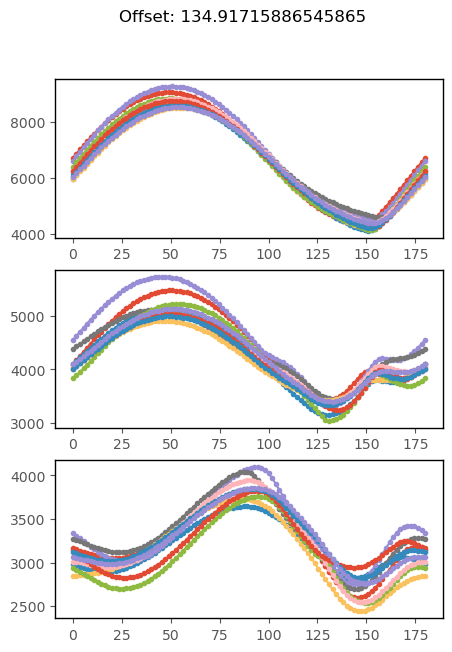

/Users/jordanando/opt/anaconda3/envs/minphys/lib/python3.11/site-packages/burnman/classes/anisotropy.py:279: RuntimeWarning: invalid value encountered in sqrt
  velocities = np.sqrt(eigenvalues / self.density)


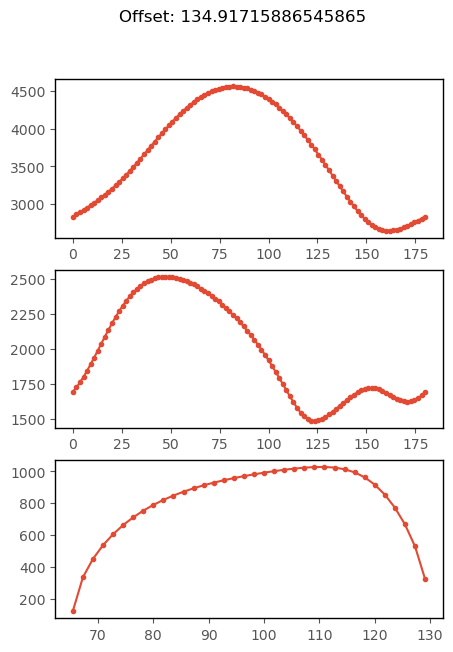

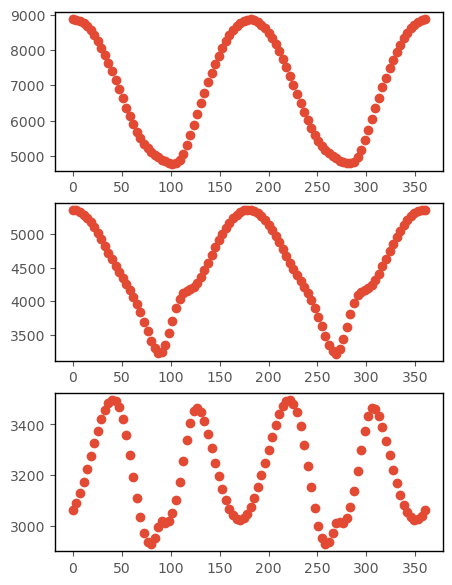

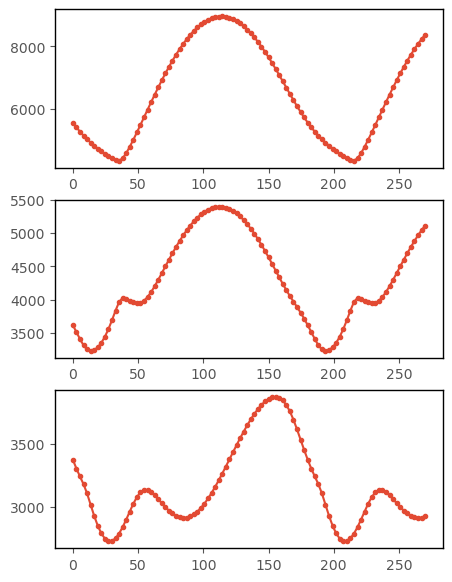

In [32]:
talc_stiffness = [219.83e9,  59.66e9,  -4.82e9,  -0.82e9, -33.87e9, -1.04e9,
                  216.38e9, -3.67e9,   1.79e9, -16.51e9,  -0.62e9,
                  48.89e9,    4.12e9, -15.52e9,  -3.59e9,
                  26.54e9,    -3.6e9,  -6.41e9,
                  22.85e9,   -1.67e9,
                  78.29e9] # Cij in Pa
rho = 2.75e3 # kg/m^3

talc_stiffness = np.array(talc_stiffness)
offset = np.random.rand() * 360
fig, ax = plt.subplots(3, 1, figsize = (5,7))

for i in range(10):
    angles, vps, vs1s, vs2s = generate_sparse_test_data(mineral_type = anisotropy.TriclinicMaterial,
                                                    Cijs = talc_stiffness * np.random.uniform(0.8, 1.2, talc_stiffness.shape),
                                                    offset = offset,
                                                    start_angle = 0.,
                                                    end_angle = 180,
                                                    hkl_norm = np.array([1,1,0]),
                                                    unit_cell_params = [5.290, 9.173, 9.460, 90.46, 98.68, 90.09],
                                                    rho = rho,
                                                    n_data = 100,
                                                    noise_mean = 0,
                                                    noise_sigma = 0)



    ax[0].plot(angles, vps, '.-')
    ax[1].plot(angles, vs1s, '.-')
    ax[2].plot(angles, vs2s, '.-')
    plt.suptitle("Offset: " + str(offset))
plt.show()

angles, vps, vs1s, vs2s = generate_sparse_test_data(mineral_type = anisotropy.TriclinicMaterial,
                                                    Cijs = talc_stiffness/np.abs(talc_stiffness) * 10e9,
                                                    offset = offset,
                                                    start_angle = 0.,
                                                    end_angle = 180,
                                                    hkl_norm = np.array([1,1,0]),
                                                    unit_cell_params = [5.290, 9.173, 9.460, 90.46, 98.68, 90.09],
                                                    rho = rho,
                                                    n_data = 100,
                                                    noise_mean = 0,
                                                    noise_sigma = 0)



fig, ax = plt.subplots(3, 1, figsize = (5,7))
ax[0].plot(angles, vps, '.-')
ax[1].plot(angles, vs1s, '.-')
ax[2].plot(angles, vs2s, '.-')
plt.suptitle("Offset: " + str(offset))
plt.show()

angles, vps, vs1s, vs2s = generate_sparse_test_data(mineral_type = anisotropy.TriclinicMaterial,
                                            Cijs = talc_stiffness,
                                            offset = 0,
                                            start_angle = 0.,
                                            end_angle = 360,
                                            hkl_norm = np.array([1,0,0]),
                                            unit_cell_params = [5.290, 9.173, 9.460, 90.46, 98.68, 90.09],
                                            rho = rho,
                                            n_data = 100,
                                            noise_mean = 0,
                                            noise_sigma = 0)



fig, ax = plt.subplots(3, 1, figsize = (5,7))
ax[0].plot(angles, vps, 'o')
ax[1].plot(angles, vs1s, 'o')
ax[2].plot(angles, vs2s, 'o')
plt.show()

angles, vps, vs1s, vs2s = generate_sparse_test_data(mineral_type = anisotropy.TriclinicMaterial,
                                            Cijs = talc_stiffness,
                                            offset = np.random.rand() * 360,
                                            start_angle = 0.,
                                            end_angle = 270,
                                            hkl_norm = np.array([1,1,0]),
                                            unit_cell_params = [5.290, 9.173, 9.460, 90.46, 98.68, 90.09],
                                            rho = rho,
                                            n_data = 100,
                                            noise_mean = 0,
                                            noise_sigma = 0)



fig, ax = plt.subplots(3, 1, figsize = (5,7))
ax[0].plot(angles, vps, '.-')
ax[1].plot(angles, vs1s, '.-')
ax[2].plot(angles, vs2s, '.-')
plt.show()

# Least squares fitting

## Triclinic Material (Talc)

In [33]:
import scipy.signal

max angle in data:  62.30769230769231
max angle in starting guess:  [ 25.40540541 205.40540541]
Early offset guess:  36.9022869022869


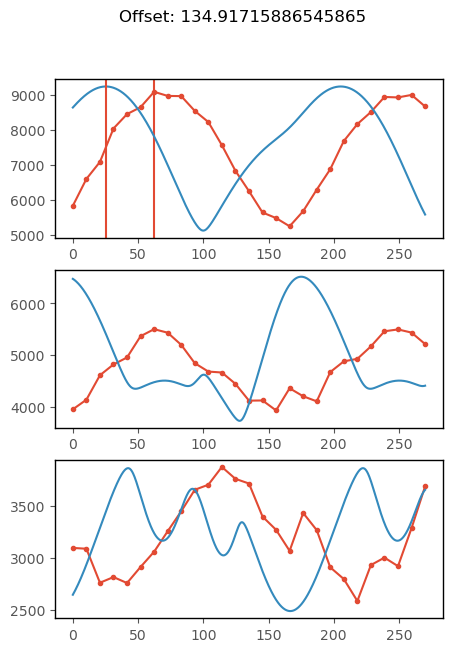

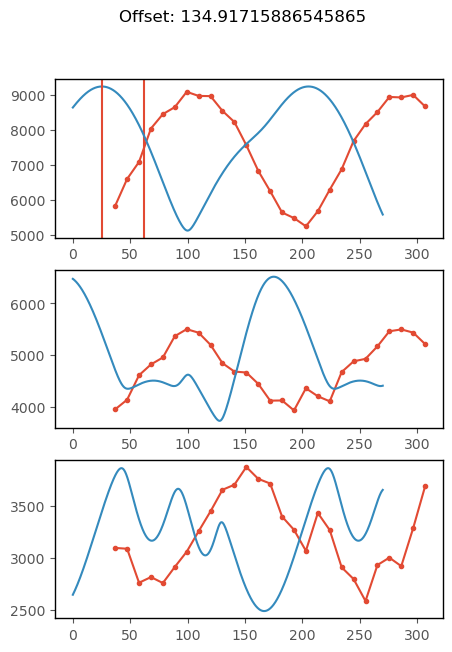

In [34]:
talc_stiffness = [219.83e9,  59.66e9,  -4.82e9,  -0.82e9, -33.87e9, -1.04e9,
                  216.38e9, -3.67e9,   1.79e9, -16.51e9,  -0.62e9,
                  48.89e9,    4.12e9, -15.52e9,  -3.59e9,
                  26.54e9,    -3.6e9,  -6.41e9,
                  22.85e9,   -1.67e9,
                  78.29e9] # Cij in Pa
rho = 2.75e3 # kg/m^3

talc_stiffness = np.array(talc_stiffness)
hkl_norm = np.array([1,2,1])
offset_true = 120

angles, vps, vs1s, vs2s = generate_sparse_test_data(mineral_type = anisotropy.TriclinicMaterial,
                                                    Cijs = talc_stiffness,
                                                    offset = offset_true,
                                                    start_angle = 0.,
                                                    end_angle = 270,
                                                    hkl_norm = hkl_norm,
                                                    unit_cell_params = [5.290, 9.173, 9.460, 90.46, 98.68, 90.09],
                                                    rho = rho,
                                                    n_data = 27,
                                                    noise_mean = 0,
                                                    noise_sigma = 1e2)


vs_stack = np.vstack([vps, vs1s, vs2s])

Cij_0 = talc_stiffness * np.random.uniform(0.5, 1.5, talc_stiffness.shape)
#Cij_0 = talc_stiffness/np.abs(talc_stiffness) * 11e9
unit_cell_params = [5.290, 9.173, 9.460, 90.46, 98.68, 90.09]

#Calculate offset
angles_o, vps_o, vs1s_o, vs2s_o = generate_sparse_test_data(mineral_type = anisotropy.TriclinicMaterial,
                                                    Cijs = Cij_0,
                                                    offset = 0,
                                                    start_angle = 0.,
                                                    end_angle = 270,
                                                    hkl_norm = hkl_norm,
                                                    unit_cell_params = unit_cell_params,
                                                    rho = rho,
                                                    n_data = 1000,
                                                    noise_mean = 0,
                                                    noise_sigma = 0)

max_angle_o = angles_o[scipy.signal.find_peaks(vps_o)[0]]
max_angle_data = angles[np.argmax(vps)]

#angle maximum in model = angle maximum in lab data - offset

offset_x = max_angle_data - max_angle_o
offset_x_idx = np.argmin(np.abs(offset_x))
offset_x = np.min(np.abs(offset_x))

print("max angle in data: ", max_angle_data)
print("max angle in starting guess: ", max_angle_o)
print("Early offset guess: ", offset_x)

fig, ax = plt.subplots(3, 1, figsize = (5,7))
ax[0].plot(angles, vps, '.-')
ax[0].axvline(max_angle_data)
ax[1].plot(angles, vs1s, '.-')
ax[2].plot(angles, vs2s, '.-')
ax[0].plot(angles_o, vps_o, '-')
ax[0].axvline(max_angle_o[offset_x_idx])
ax[1].plot(angles_o, vs1s_o, '-')
ax[2].plot(angles_o, vs2s_o, '-')
plt.suptitle("Offset: " + str(offset))
plt.show()

fig, ax = plt.subplots(3, 1, figsize = (5,7))
ax[0].plot(angles+offset_x, vps, '.-')
ax[0].axvline(max_angle_data)
ax[1].plot(angles+offset_x, vs1s, '.-')
ax[2].plot(angles+offset_x, vs2s, '.-')
ax[0].plot(angles_o, vps_o, '-')
ax[0].axvline(max_angle_o[offset_x_idx])
ax[1].plot(angles_o, vs1s_o, '-')
ax[2].plot(angles_o, vs2s_o, '-')
plt.suptitle("Offset: " + str(offset))
plt.show()



In [35]:
fit_result, err = fit_Cij_lsq_old(xs = angles,
                     ys = vs_stack,
                     theta_0 = np.append(Cij_0, offset_x),
                     mineral_type = anisotropy.TriclinicMaterial,
                     rho = rho,
                     hkl_norm=hkl_norm,
                     unit_cell_params=unit_cell_params
                     )

Cij_fit = fit_result[:-1]

print(Cij_fit)
print(err)

`xtol` termination condition is satisfied.
Function evaluations 75, initial cost 1.1353e+08, final cost 4.9555e+05, first-order optimality 2.59e-01.
[ 1.81589429e+11  1.27121818e+11 -3.12393602e+10 -1.21025285e+10
 -1.25900320e+10  6.07975692e+10  2.45581628e+11 -1.39824213e+10
 -5.99567417e+10 -6.49760550e+10  3.23213895e+10  8.39716131e+10
  1.99889321e+09  2.41564056e+10 -2.55850733e+09  8.21235204e+10
  1.97803180e+10 -3.06485542e+10  4.24970157e+10 -3.86307670e+10
  1.69163914e+10  3.76343068e+01]
[ 1.81589429e+11  1.27121818e+11 -3.12393602e+10 -1.21025285e+10
 -1.25900320e+10  6.07975692e+10  2.45581628e+11 -1.39824213e+10
 -5.99567417e+10 -6.49760550e+10  3.23213895e+10  8.39716131e+10
  1.99889321e+09  2.41564056e+10 -2.55850733e+09  8.21235204e+10
  1.97803180e+10 -3.06485542e+10  4.24970157e+10 -3.86307670e+10
  1.69163914e+10]
[6.92742353e+13 5.88882393e+13 8.40270027e+12 1.36361047e+13
 1.42315296e+13 3.39650379e+13 8.49096456e+13 1.58877037e+13
 3.84027005e+13 3.55180390e

<Figure size 1600x1000 with 0 Axes>

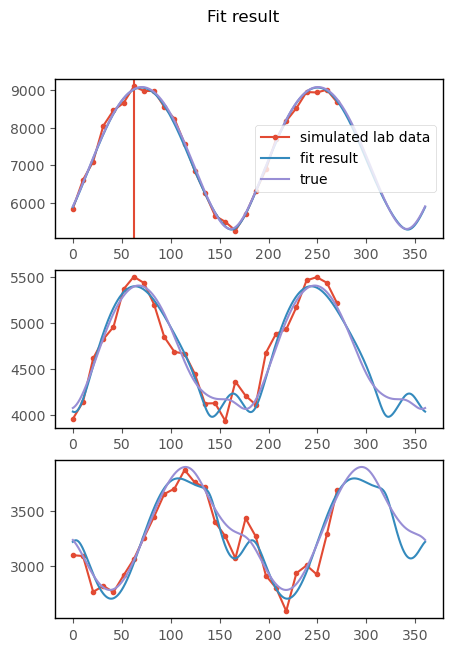

In [36]:
angles_fit, vps_fit, vs1s_fit, vs2s_fit = generate_sparse_test_data(mineral_type = anisotropy.TriclinicMaterial,
                                                    Cijs = Cij_fit,
                                                    offset = fit_result[-1],
                                                    start_angle = 0.,
                                                    end_angle = 360,
                                                    hkl_norm = hkl_norm,
                                                    unit_cell_params = unit_cell_params,
                                                    rho = rho,
                                                    n_data = 1000,
                                                    noise_mean = 0,
                                                    noise_sigma = 0)

angles_true, vps_true, vs1s_true, vs2s_true = generate_sparse_test_data(mineral_type = anisotropy.TriclinicMaterial,
                                                    Cijs = talc_stiffness,
                                                    offset = offset_true,
                                                    start_angle = 0.,
                                                    end_angle = 360,
                                                    hkl_norm = hkl_norm,
                                                    unit_cell_params = unit_cell_params,
                                                    rho = rho,
                                                    n_data = 1000,
                                                    noise_mean = 0,
                                                    noise_sigma = 0)



fig, ax = plt.subplots(3, 1, figsize = (5,7))
ax[0].plot(angles, vps, '.-', label = "simulated lab data")
ax[0].axvline(max_angle_data)
ax[1].plot(angles, vs1s, '.-')
ax[2].plot(angles, vs2s, '.-')
ax[0].plot(angles_fit, vps_fit, '-', label = "fit result")
ax[1].plot(angles_fit, vs1s_fit, '-')
ax[2].plot(angles_fit, vs2s_fit, '-')
ax[0].plot(angles_true, vps_true, '-', label = "true")
ax[1].plot(angles_true, vs1s_true, '-')
ax[2].plot(angles_true, vs2s_true, '-')
plt.suptitle("Fit result")
ax[0].legend()
plt.show()

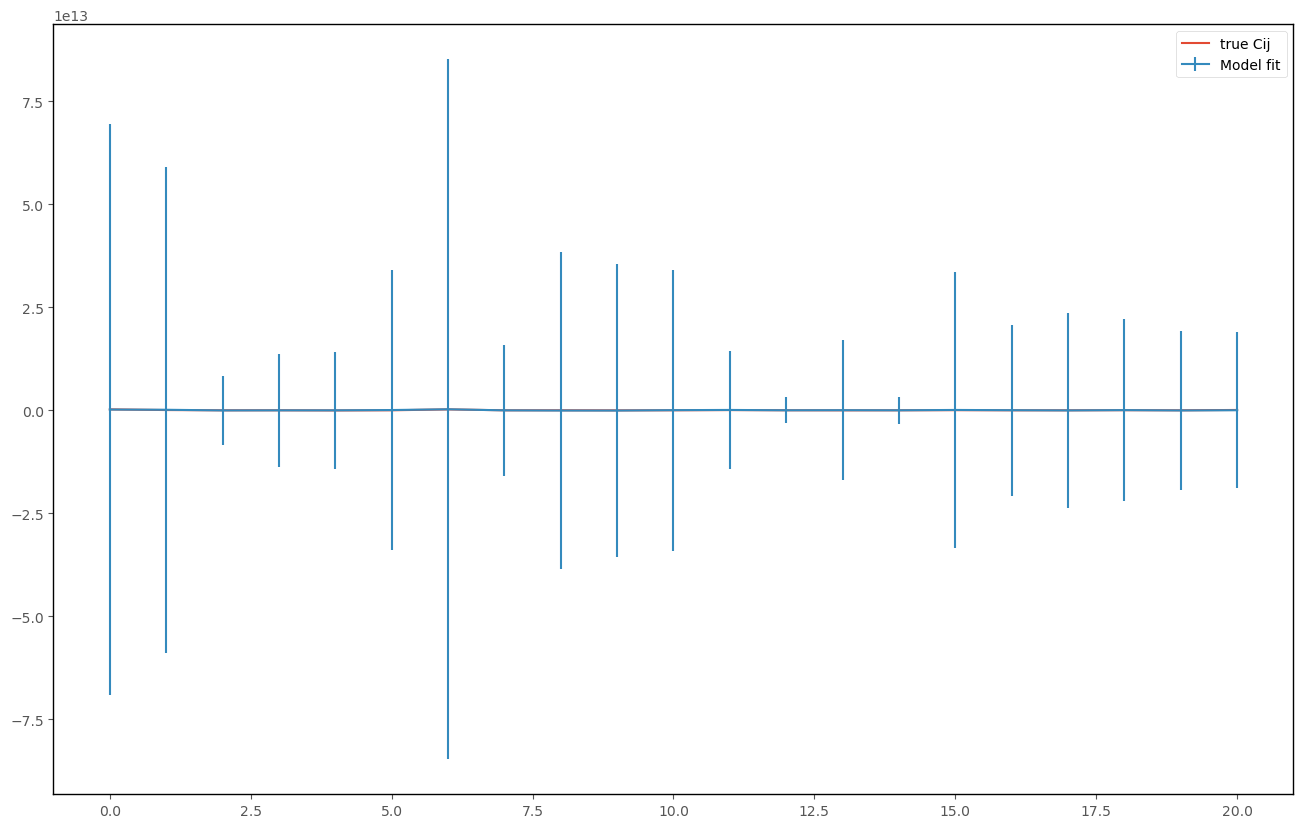

In [37]:
plt.figure()
plt.plot(talc_stiffness, label = "true Cij")
plt.errorbar(x = range(len(Cij_fit)),y = Cij_fit, yerr = err[:-1], label= "Model fit")
plt.legend()
plt.show()

It works!

In [38]:
print(talc_stiffness)

[ 2.1983e+11  5.9660e+10 -4.8200e+09 -8.2000e+08 -3.3870e+10 -1.0400e+09
  2.1638e+11 -3.6700e+09  1.7900e+09 -1.6510e+10 -6.2000e+08  4.8890e+10
  4.1200e+09 -1.5520e+10 -3.5900e+09  2.6540e+10 -3.6000e+09 -6.4100e+09
  2.2850e+10 -1.6700e+09  7.8290e+10]


## Tetragonal Material (Shistovite)


In [39]:
stishovite_stiffness = [455e9,  199e9,  192e9,  762e9, 258e9, 321e9]
stishovite_stiffness = np.array(stishovite_stiffness)

max angle in data:  93.46153846153847
max angle in starting guess:  [ 82.97297297 262.97297297]
Early offset guess:  10.488565488565484


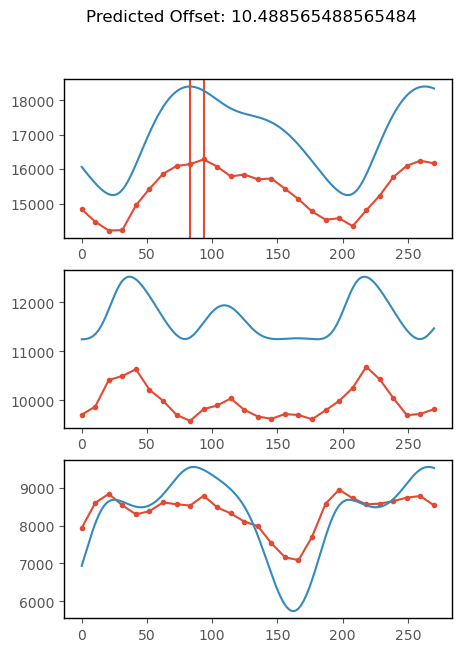

`xtol` termination condition is satisfied.
Function evaluations 9, initial cost 8.9604e+07, final cost 4.9629e+05, first-order optimality 1.71e+01.
[4.54748684e+11 2.05242536e+11 1.92668157e+11 7.62534978e+11
 2.57165935e+11 3.22405336e+11 7.58074908e-01]


<Figure size 1600x1000 with 0 Axes>

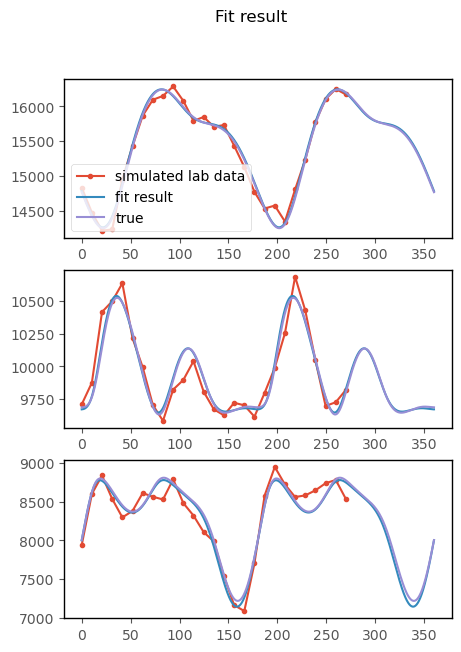

[3.38020180e+07 4.58809146e+07 2.77780311e+07 6.72662993e+07
 2.00747633e+07 2.72206464e+07 4.80049721e-03]


In [40]:
hkl_norm = np.array([1,2,1])
offset_true = 0
unit_cell_params = [4.1801, 4.1801, 2.6678, 90, 90, 90]
rho = 2.75e3

angles, vps, vs1s, vs2s = generate_sparse_test_data(mineral_type = anisotropy.TetragonalMaterial,
                                                Cijs = stishovite_stiffness,
                                                offset = offset_true,
                                                start_angle = 0.,
                                                end_angle = 270,
                                                hkl_norm = hkl_norm,
                                                unit_cell_params = unit_cell_params,
                                                rho = rho,
                                                n_data = 27,
                                                noise_mean = 0,
                                                noise_sigma =1e2)


vs_stack = np.vstack([vps, vs1s, vs2s])

Cij_0 = stishovite_stiffness * np.random.uniform(0.4, 1.7, stishovite_stiffness.shape)

#Calculate offset
angles_o, vps_o, vs1s_o, vs2s_o = generate_sparse_test_data(mineral_type = anisotropy.TetragonalMaterial,
                                                Cijs = Cij_0,
                                                offset = 0,
                                                start_angle = 0.,
                                                end_angle = 270,
                                                hkl_norm = hkl_norm,
                                                unit_cell_params = unit_cell_params,
                                                rho = rho,
                                                n_data = 1000,
                                                noise_mean = 0,
                                                noise_sigma = 0)


max_angle_o = angles_o[scipy.signal.find_peaks(vps_o)[0]]
max_angle_data = angles[np.argmax(vps)]

#angle maximum in model = angle maximum in lab data - offset

offset_x = max_angle_data - max_angle_o
offset_x_idx = np.argmin(np.abs(offset_x))
offset_x = np.min(np.abs(offset_x))

print("max angle in data: ", max_angle_data)
print("max angle in starting guess: ", max_angle_o)
print("Early offset guess: ", offset_x)

fig, ax = plt.subplots(3, 1, figsize = (5,7))
ax[0].plot(angles, vps, '.-')
ax[0].axvline(max_angle_data)
ax[1].plot(angles, vs1s, '.-')
ax[2].plot(angles, vs2s, '.-')
ax[0].plot(angles_o, vps_o, '-')
ax[0].axvline(max_angle_o[offset_x_idx])
ax[1].plot(angles_o, vs1s_o, '-')
ax[2].plot(angles_o, vs2s_o, '-')
plt.suptitle("Predicted Offset: " + str(offset_x))
plt.show()




fit_result, err = fit_Cij_lsq_old(xs = angles,
                    ys = vs_stack,
                    theta_0 = np.append(Cij_0, offset_x),
                    mineral_type = anisotropy.TetragonalMaterial,
                    rho = rho,
                    hkl_norm=hkl_norm,
                    unit_cell_params=unit_cell_params
                    )

Cij_fit = fit_result[:-1]

angles_fit, vps_fit, vs1s_fit, vs2s_fit = generate_sparse_test_data(mineral_type = anisotropy.TetragonalMaterial,
                                                                    Cijs = Cij_fit,
                                                                    offset = fit_result[-1],
                                                                    start_angle = 0.,
                                                                    end_angle = 360,
                                                                    hkl_norm = hkl_norm,
                                                                    unit_cell_params = unit_cell_params,
                                                                    rho = rho,
                                                                    n_data = 1000,
                                                                    noise_mean = 0,
                                                                    noise_sigma = 0)

angles_true, vps_true, vs1s_true, vs2s_true = generate_sparse_test_data(mineral_type = anisotropy.TetragonalMaterial,
                                                Cijs = stishovite_stiffness,
                                                offset = offset_true,
                                                start_angle = 0.,
                                                end_angle = 360,
                                                hkl_norm = hkl_norm,
                                                unit_cell_params = unit_cell_params,
                                                rho = rho,
                                                n_data = 1000,
                                                noise_mean = 0,
                                                noise_sigma = 0)



fig, ax = plt.subplots(3, 1, figsize = (5,7))
ax[0].plot(angles, vps, '.-', label = "simulated lab data")
ax[1].plot(angles, vs1s, '.-')
ax[2].plot(angles, vs2s, '.-')
ax[0].plot(angles_fit, vps_fit, '-', label = "fit result")
ax[1].plot(angles_fit, vs1s_fit, '-')
ax[2].plot(angles_fit, vs2s_fit, '-')
ax[0].plot(angles_true, vps_true, '-', label = "true")
ax[1].plot(angles_true, vs1s_true, '-')
ax[2].plot(angles_true, vs2s_true, '-')
plt.suptitle("Fit result")
ax[0].legend()
plt.show()

print(err)

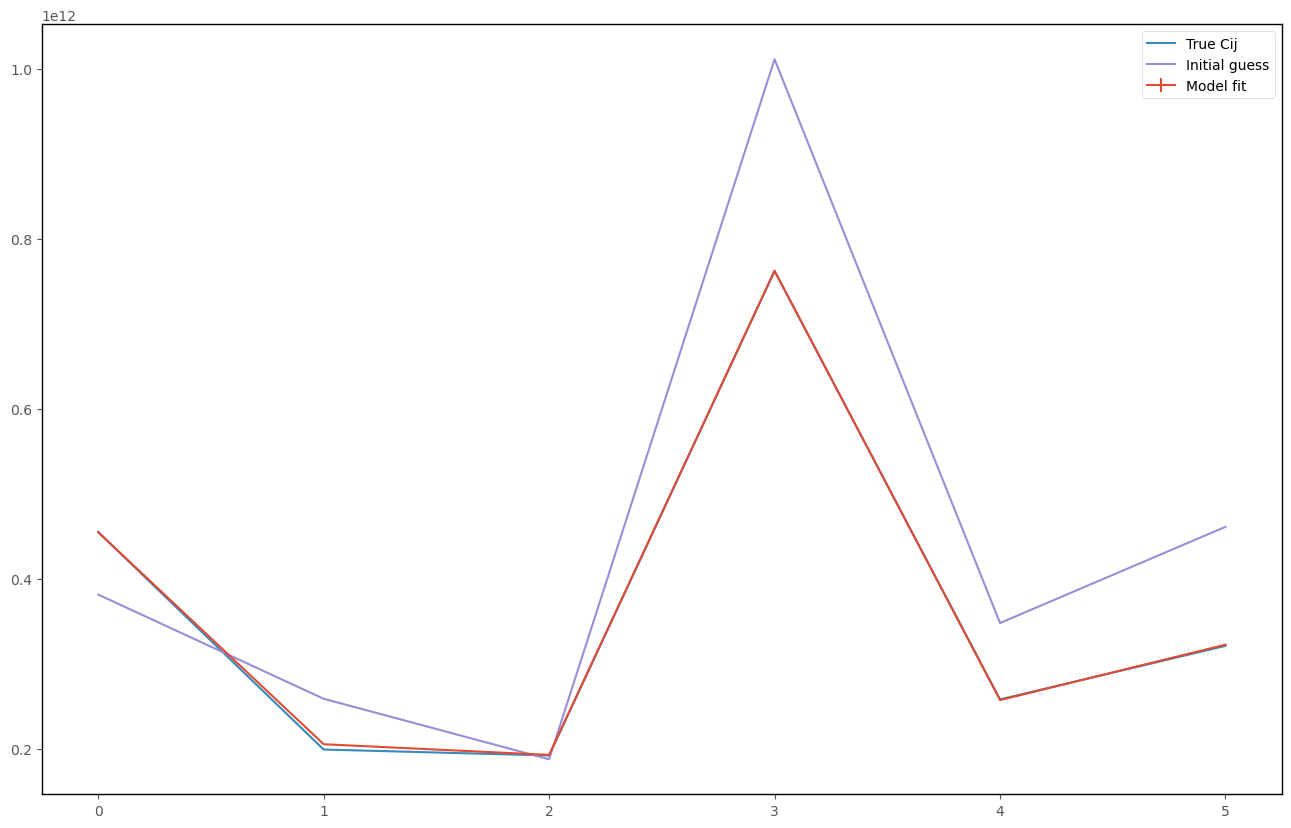

In [41]:
plt.figure()
plt.errorbar(x = range(len(Cij_fit)),y = Cij_fit, yerr = err[:-1], label= "Model fit")
plt.plot(stishovite_stiffness, label = "True Cij")
plt.plot(Cij_0, label = "Initial guess")
plt.legend()
plt.show()

## MgO (Cubic)

max angle in data:  135.0
max angle in starting guess:  [ 44.86486486 135.13513514 224.86486486]
Early offset guess:  0.13513513513512976


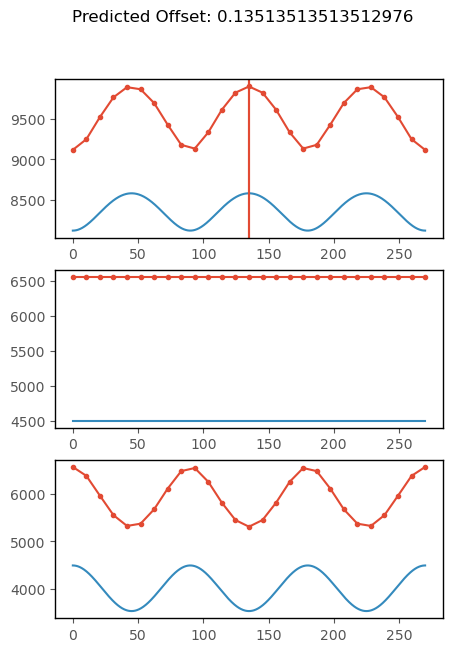

`xtol` termination condition is satisfied.
Function evaluations 6, initial cost 1.2538e+08, final cost 8.3545e-23, first-order optimality 9.36e-08.
[2.97900000e+11 9.58000000e+10 1.54400000e+11 2.16860958e-14]


<Figure size 1600x1000 with 0 Axes>

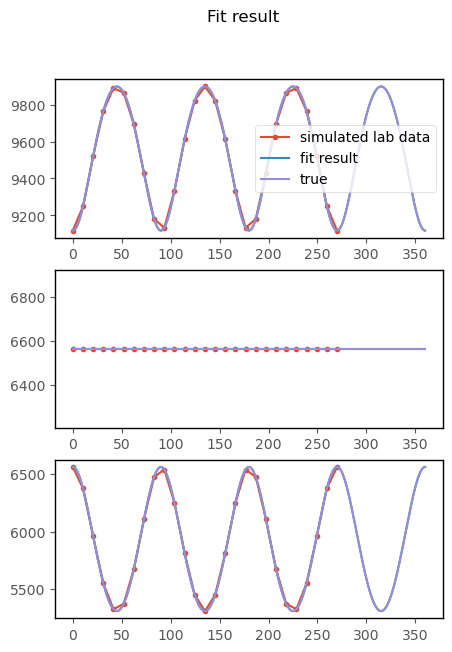

[1.51282372e+07 2.14570972e+07 7.65916210e+06 5.38754723e-03]


In [42]:
mgo_stiffness = [297.9e9, 95.8e9, 154.4e9]
mgo_stiffness = np.array(mgo_stiffness)

hkl_norm = np.array([1,0,0])
offset_true = 0
unit_cell_params = [ 4.211, 4.211, 4.211, 90, 90, 90]
rho = 3.584e3

angles, vps, vs1s, vs2s = generate_sparse_test_data(mineral_type = anisotropy.CubicMaterial,
                                                Cijs = mgo_stiffness,
                                                offset = offset_true,
                                                start_angle = 0.,
                                                end_angle = 270,
                                                hkl_norm = hkl_norm,
                                                unit_cell_params = unit_cell_params,
                                                rho = rho,
                                                n_data = 27,
                                                noise_mean = 0,
                                                noise_sigma =0)


vs_stack = np.vstack([vps, vs1s, vs2s])

Cij_0 = mgo_stiffness * np.random.uniform(0.4, 1.7, mgo_stiffness.shape)

#Calculate offset
angles_o, vps_o, vs1s_o, vs2s_o = generate_sparse_test_data(mineral_type = anisotropy.CubicMaterial,
                                                Cijs = Cij_0,
                                                offset = 0,
                                                start_angle = 0.,
                                                end_angle = 270,
                                                hkl_norm = hkl_norm,
                                                unit_cell_params = unit_cell_params,
                                                rho = rho,
                                                n_data = 1000,
                                                noise_mean = 0,
                                                noise_sigma = 0)


max_angle_o = angles_o[scipy.signal.find_peaks(vps_o)[0]]
max_angle_data = angles[np.argmax(vps)]

#angle maximum in model = angle maximum in lab data - offset

offset_x = max_angle_data - max_angle_o
offset_x_idx = np.argmin(np.abs(offset_x))
offset_x = np.min(np.abs(offset_x))

print("max angle in data: ", max_angle_data)
print("max angle in starting guess: ", max_angle_o)
print("Early offset guess: ", offset_x)

fig, ax = plt.subplots(3, 1, figsize = (5,7))
ax[0].plot(angles, vps, '.-')
ax[0].axvline(max_angle_data)
ax[1].plot(angles, vs1s, '.-')
ax[2].plot(angles, vs2s, '.-')
ax[0].plot(angles_o, vps_o, '-')
ax[0].axvline(max_angle_o[offset_x_idx])
ax[1].plot(angles_o, vs1s_o, '-')
ax[2].plot(angles_o, vs2s_o, '-')
plt.suptitle("Predicted Offset: " + str(offset_x))
plt.show()




fit_result, err = fit_Cij_lsq_old(xs = angles,
                    ys = vs_stack,
                    theta_0 = np.append(Cij_0, offset_x),
                    mineral_type = anisotropy.CubicMaterial,
                    rho = rho,
                    hkl_norm=hkl_norm,
                    unit_cell_params=unit_cell_params
                    )

Cij_fit = fit_result[:-1]

angles_fit, vps_fit, vs1s_fit, vs2s_fit = generate_sparse_test_data(mineral_type = anisotropy.CubicMaterial,
                                                                    Cijs = Cij_fit,
                                                                    offset = fit_result[-1],
                                                                    start_angle = 0.,
                                                                    end_angle = 360,
                                                                    hkl_norm = hkl_norm,
                                                                    unit_cell_params = unit_cell_params,
                                                                    rho = rho,
                                                                    n_data = 1000,
                                                                    noise_mean = 0,
                                                                    noise_sigma = 0)

angles_true, vps_true, vs1s_true, vs2s_true = generate_sparse_test_data(mineral_type = anisotropy.CubicMaterial,
                                                Cijs = mgo_stiffness,
                                                offset = offset_true,
                                                start_angle = 0.,
                                                end_angle = 360,
                                                hkl_norm = hkl_norm,
                                                unit_cell_params = unit_cell_params,
                                                rho = rho,
                                                n_data = 1000,
                                                noise_mean = 0,
                                                noise_sigma = 0)



fig, ax = plt.subplots(3, 1, figsize = (5,7))
ax[0].plot(angles, vps, '.-', label = "simulated lab data")
ax[1].plot(angles, vs1s, '.-')
ax[2].plot(angles, vs2s, '.-')
ax[0].plot(angles_fit, vps_fit, '-', label = "fit result")
ax[1].plot(angles_fit, vs1s_fit, '-')
ax[2].plot(angles_fit, vs2s_fit, '-')
ax[0].plot(angles_true, vps_true, '-', label = "true")
ax[1].plot(angles_true, vs1s_true, '-')
ax[2].plot(angles_true, vs2s_true, '-')
plt.suptitle("Fit result")
ax[0].legend()
plt.show()

print(err)

# Fe Bearing beta (Wadsleyite)

max angle in data:  343.4068136272545
max angle in starting guess:  [ 77.56756757 257.56756757]
Early offset guess:  85.8392460596869


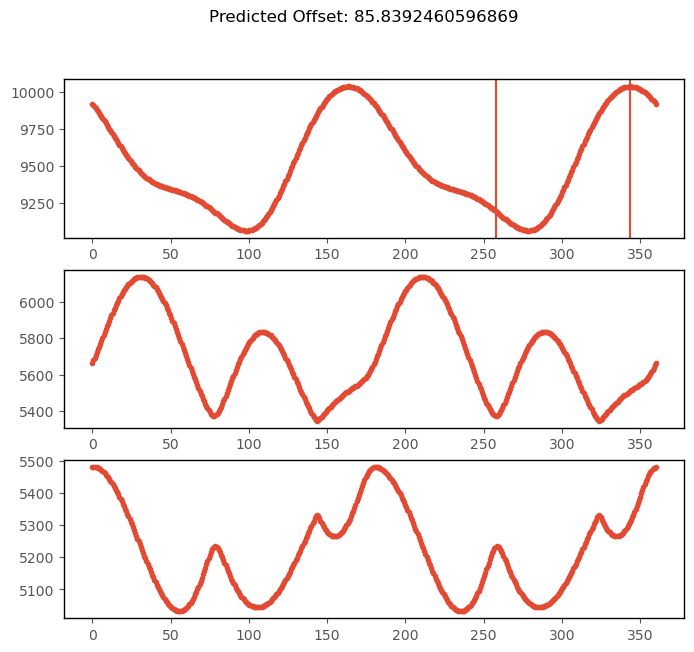

'\nfit_result, err = fit_Cij_lsq_old(xs = angles,\n                    ys = vs_stack,\n                    theta_0 = np.append(Cij_0, offset_x),\n                    mineral_type = anisotropy.OrthorhombicMaterial,\n                    rho = rho,\n                    hkl_norm=hkl_norm,\n                    unit_cell_params=unit_cell_params\n                    )\n\nCij_fit = fit_result[:-1]\n\nangles_fit, vps_fit, vs1s_fit, vs2s_fit = generate_sparse_test_data(mineral_type = anisotropy.OrthorhombicMaterial,\n                                                                    Cijs = Cij_fit,\n                                                                    offset = fit_result[-1],\n                                                                    start_angle = 0.,\n                                                                    end_angle = 360,\n                                                                    hkl_norm = hkl_norm,\n                                             

In [43]:
mgo_stiffness = [348, 78, 102,372, 105, 254, 106, 115, 97]
mgo_stiffness = np.array(mgo_stiffness) * 1e9

hkl_norm = np.array([1,2,1])
offset_true = 0
unit_cell_params = [5.6884, 28.9238, 8.2382, 90, 90, 90]
rho = 3.57e3

#hkl_norm = convert_cartesian_to_miller(xyz = hkl_norm, unit_cell_params=unit_cell_params)

angles, vps, vs1s, vs2s = generate_sparse_test_data(mineral_type = anisotropy.OrthorhombicMaterial,
                                                Cijs = mgo_stiffness,
                                                offset = offset_true,
                                                start_angle = 0.,
                                                end_angle = 360,
                                                hkl_norm = hkl_norm,
                                                unit_cell_params = unit_cell_params,
                                                rho = rho,
                                                n_data = 500,
                                                noise_mean = 0,
                                                noise_sigma =0)


vs_stack = np.vstack([vps, vs1s, vs2s])

Cij_0 = mgo_stiffness * np.random.uniform(0.4, 1.7, mgo_stiffness.shape)

#Calculate offset
angles_o, vps_o, vs1s_o, vs2s_o = generate_sparse_test_data(mineral_type = anisotropy.OrthorhombicMaterial,
                                                Cijs = Cij_0,
                                                offset = 0,
                                                start_angle = 0.,
                                                end_angle = 270,
                                                hkl_norm = hkl_norm,
                                                unit_cell_params = unit_cell_params,
                                                rho = rho,
                                                n_data = 1000,
                                                noise_mean = 0,
                                                noise_sigma = 0)


max_angle_o = angles_o[scipy.signal.find_peaks(vps_o)[0]]
max_angle_data = angles[np.argmax(vps)]

#angle maximum in model = angle maximum in lab data - offset

offset_x = max_angle_data - max_angle_o
offset_x_idx = np.argmin(np.abs(offset_x))
offset_x = np.min(np.abs(offset_x))

print("max angle in data: ", max_angle_data)
print("max angle in starting guess: ", max_angle_o)
print("Early offset guess: ", offset_x)

fig, ax = plt.subplots(3, 1, figsize = (8,7))
ax[0].plot(angles, vps, '.-')
ax[0].axvline(max_angle_data)
ax[1].plot(angles, vs1s, '.-')
ax[2].plot(angles, vs2s, '.-')
#ax[0].plot(angles_o, vps_o, '-')
ax[0].axvline(max_angle_o[offset_x_idx])
#ax[1].plot(angles_o, vs1s_o, '-')
#ax[2].plot(angles_o, vs2s_o, '-')
plt.suptitle("Predicted Offset: " + str(offset_x))
plt.show()



"""
fit_result, err = fit_Cij_lsq_old(xs = angles,
                    ys = vs_stack,
                    theta_0 = np.append(Cij_0, offset_x),
                    mineral_type = anisotropy.OrthorhombicMaterial,
                    rho = rho,
                    hkl_norm=hkl_norm,
                    unit_cell_params=unit_cell_params
                    )

Cij_fit = fit_result[:-1]

angles_fit, vps_fit, vs1s_fit, vs2s_fit = generate_sparse_test_data(mineral_type = anisotropy.OrthorhombicMaterial,
                                                                    Cijs = Cij_fit,
                                                                    offset = fit_result[-1],
                                                                    start_angle = 0.,
                                                                    end_angle = 360,
                                                                    hkl_norm = hkl_norm,
                                                                    unit_cell_params = unit_cell_params,
                                                                    rho = rho,
                                                                    n_data = 1000,
                                                                    noise_mean = 0,
                                                                    noise_sigma = 0)

angles_true, vps_true, vs1s_true, vs2s_true = generate_sparse_test_data(mineral_type = anisotropy.OrthorhombicMaterial,
                                                Cijs = mgo_stiffness,
                                                offset = offset_true,
                                                start_angle = 0.,
                                                end_angle = 360,
                                                hkl_norm = hkl_norm,
                                                unit_cell_params = unit_cell_params,
                                                rho = rho,
                                                n_data = 1000,
                                                noise_mean = 0,
                                                noise_sigma = 0)



fig, ax = plt.subplots(3, 1, figsize = (5,7))
ax[0].plot(angles, vps, '.-', label = "simulated lab data")
ax[1].plot(angles, vs1s, '.-')
ax[2].plot(angles, vs2s, '.-')
ax[0].plot(angles_fit, vps_fit, '-', label = "fit result")
ax[1].plot(angles_fit, vs1s_fit, '-')
ax[2].plot(angles_fit, vs2s_fit, '-')
ax[0].plot(angles_true, vps_true, '-', label = "true")
ax[1].plot(angles_true, vs1s_true, '-')
ax[2].plot(angles_true, vs2s_true, '-')
plt.suptitle("Fit result")
ax[0].legend()
plt.show()

print(err)"""

max angle in data:  25.25050100200401
max angle in starting guess:  [ 25.250501   205.61122244]
Early offset guess:  0.0


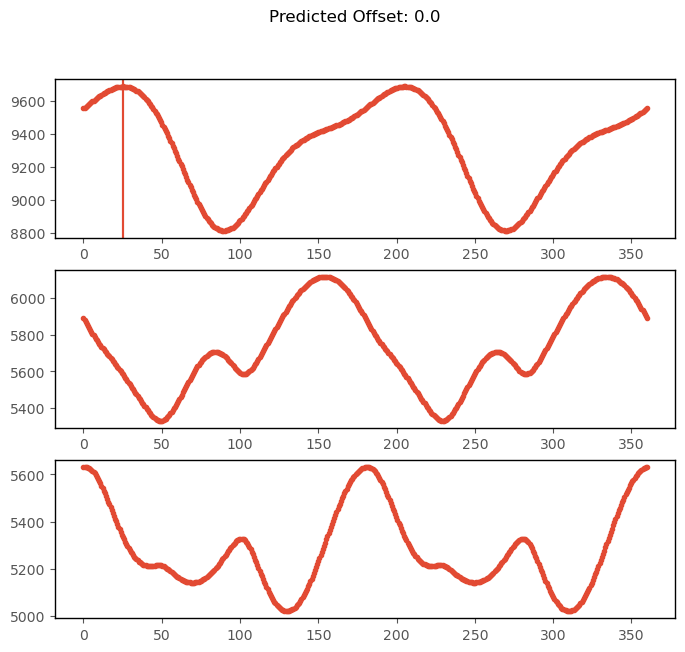

'\n\nfit_result, err = fit_Cij_lsq_old(xs = angles,\n                    ys = vs_stack,\n                    theta_0 = np.append(Cij_0, offset_x),\n                    mineral_type = anisotropy.OrthorhombicMaterial,\n                    rho = rho,\n                    hkl_norm=hkl_norm,\n                    unit_cell_params=unit_cell_params\n                    )\n\nCij_fit = fit_result[:-1]\n\nangles_fit, vps_fit, vs1s_fit, vs2s_fit = generate_sparse_test_data(mineral_type = anisotropy.OrthorhombicMaterial,\n                                                                    Cijs = Cij_fit,\n                                                                    offset = fit_result[-1],\n                                                                    start_angle = 0.,\n                                                                    end_angle = 360,\n                                                                    hkl_norm = hkl_norm,\n                                           

In [44]:
mgo_stiffness = [348, 78, 102,372, 105, 254, 106, 115, 97]
mgo_stiffness = np.array(mgo_stiffness) * 1e9

xyz_norm = np.array([1,2,1])
offset_true = 0
unit_cell_params = [5.6884, 28.9238, 8.2382, 90, 90, 90]
rho = 3.57e3

#hkl_norm = convert_cartesian_to_miller(xyz = hkl_norm, unit_cell_params=unit_cell_params)

angles, vps, vs1s, vs2s = generate_sparse_test_data(mineral_type = anisotropy.OrthorhombicMaterial,
                                                Cijs = mgo_stiffness,
                                                offset = offset_true,
                                                start_angle = 0.,
                                                end_angle = 360,
                                                xyz_norm = xyz_norm,
                                                rho = rho,
                                                n_data = 500,
                                                noise_mean = 0,
                                                noise_sigma =0)


vs_stack = np.vstack([vps, vs1s, vs2s])

Cij_0 = mgo_stiffness * np.random.uniform(0.4, 1.7, mgo_stiffness.shape)

#Calculate offset
angles_o, vps_o, vs1s_o, vs2s_o = generate_sparse_test_data(mineral_type = anisotropy.OrthorhombicMaterial,
                                                Cijs = mgo_stiffness,
                                                offset = offset_true,
                                                start_angle = 0.,
                                                end_angle = 360,
                                                xyz_norm = xyz_norm,
                                                rho = rho,
                                                n_data = 500,
                                                noise_mean = 0,
                                                noise_sigma =0)


max_angle_o = angles_o[scipy.signal.find_peaks(vps_o)[0]]
max_angle_data = angles[np.argmax(vps)]

#angle maximum in model = angle maximum in lab data - offset

offset_x = max_angle_data - max_angle_o
offset_x_idx = np.argmin(np.abs(offset_x))
offset_x = np.min(np.abs(offset_x))

print("max angle in data: ", max_angle_data)
print("max angle in starting guess: ", max_angle_o)
print("Early offset guess: ", offset_x)

fig, ax = plt.subplots(3, 1, figsize = (8,7))
ax[0].plot(angles, vps, '.-')
ax[0].axvline(max_angle_data)
ax[1].plot(angles, vs1s, '.-')
ax[2].plot(angles, vs2s, '.-')
#ax[0].plot(angles_o, vps_o, '-')
ax[0].axvline(max_angle_o[offset_x_idx])
#ax[1].plot(angles_o, vs1s_o, '-')
#ax[2].plot(angles_o, vs2s_o, '-')
plt.suptitle("Predicted Offset: " + str(offset_x))
plt.show()


"""

fit_result, err = fit_Cij_lsq_old(xs = angles,
                    ys = vs_stack,
                    theta_0 = np.append(Cij_0, offset_x),
                    mineral_type = anisotropy.OrthorhombicMaterial,
                    rho = rho,
                    hkl_norm=hkl_norm,
                    unit_cell_params=unit_cell_params
                    )

Cij_fit = fit_result[:-1]

angles_fit, vps_fit, vs1s_fit, vs2s_fit = generate_sparse_test_data(mineral_type = anisotropy.OrthorhombicMaterial,
                                                                    Cijs = Cij_fit,
                                                                    offset = fit_result[-1],
                                                                    start_angle = 0.,
                                                                    end_angle = 360,
                                                                    hkl_norm = hkl_norm,
                                                                    unit_cell_params = unit_cell_params,
                                                                    rho = rho,
                                                                    n_data = 1000,
                                                                    noise_mean = 0,
                                                                    noise_sigma = 0)

angles_true, vps_true, vs1s_true, vs2s_true = generate_sparse_test_data(mineral_type = anisotropy.OrthorhombicMaterial,
                                                Cijs = mgo_stiffness,
                                                offset = offset_true,
                                                start_angle = 0.,
                                                end_angle = 360,
                                                hkl_norm = hkl_norm,
                                                unit_cell_params = unit_cell_params,
                                                rho = rho,
                                                n_data = 1000,
                                                noise_mean = 0,
                                                noise_sigma = 0)



fig, ax = plt.subplots(3, 1, figsize = (5,7))
ax[0].plot(angles, vps, '.-', label = "simulated lab data")
ax[1].plot(angles, vs1s, '.-')
ax[2].plot(angles, vs2s, '.-')
ax[0].plot(angles_fit, vps_fit, '-', label = "fit result")
ax[1].plot(angles_fit, vs1s_fit, '-')
ax[2].plot(angles_fit, vs2s_fit, '-')
ax[0].plot(angles_true, vps_true, '-', label = "true")
ax[1].plot(angles_true, vs1s_true, '-')
ax[2].plot(angles_true, vs2s_true, '-')
plt.suptitle("Fit result")
ax[0].legend()
plt.show()

print(err)"""

# Shistovite (different angles for each velocity)

[  0.   22.5  45.   67.5  90.  112.5 135.  157.5 180.  202.5 225.  247.5
 270. ]
[ 10.   32.5  55.   77.5 100.  122.5 145.  167.5 190.  212.5 235.  257.5
 280. ]


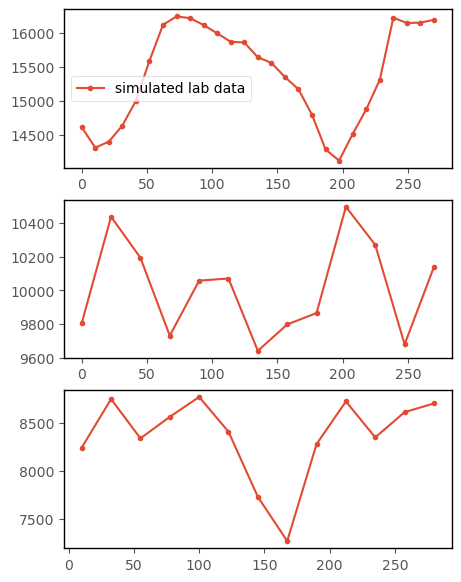

`xtol` termination condition is satisfied.
Function evaluations 16, initial cost 3.5475e+06, final cost 5.1726e+05, first-order optimality 3.90e+01.
Fit parameters:  [4.51330610e+11 2.13448166e+11 1.85432581e+11 7.63531537e+11
 2.66316458e+11 3.09941502e+11 2.25619568e+00]
Standard deviation:  [[ 1.62040935e+15  9.40577312e+14  2.89651772e+14 -5.84347339e+14
  -1.83604633e+14 -7.51348444e+14  9.23605931e+03]
 [ 9.40577312e+14  3.36565975e+15 -3.61742416e+14 -8.60067697e+14
   1.13215001e+14 -1.00340069e+15  1.08286513e+05]
 [ 2.89651772e+14 -3.61742416e+14  1.24334602e+15  2.23492185e+14
  -3.12388254e+14  7.27950209e+13 -5.64722749e+04]
 [-5.84347339e+14 -8.60067697e+14  2.23492185e+14  5.83404869e+15
  -1.28009455e+15  6.51073282e+14  2.67834588e+04]
 [-1.83604633e+14  1.13215001e+14 -3.12388254e+14 -1.28009455e+15
   7.30801284e+14 -2.91872643e+14 -3.72509729e+04]
 [-7.51348444e+14 -1.00340069e+15  7.27950209e+13  6.51073282e+14
  -2.91872643e+14  1.40287127e+15  2.06461545e+04]
 [ 

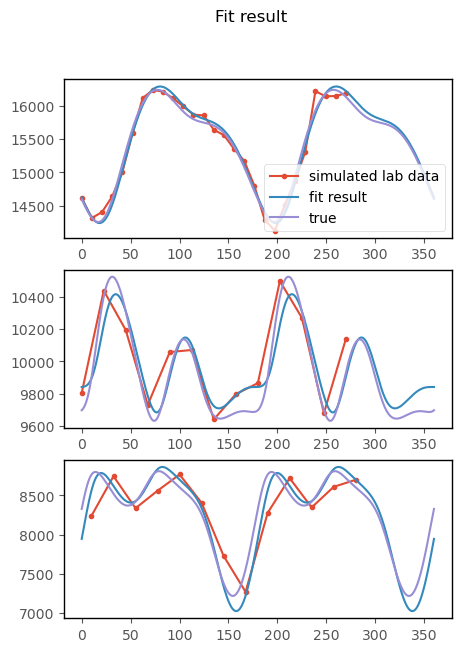

[4.02543085e+07 5.80143064e+07 3.52611120e+07 7.63809445e+07
 2.70333365e+07 3.74549231e+07 6.07974064e-03]


In [53]:
hkl_norm = np.array([1,2,1])
offset_true = 5
unit_cell_params = [4.1801, 4.1801, 2.6678, 90, 90, 90]
rho = 2.75e3

angles_vps, vps, _, _ = generate_sparse_test_data(mineral_type = anisotropy.TetragonalMaterial,
                                                Cijs = stishovite_stiffness,
                                                offset = offset_true,
                                                start_angle = 0,
                                                end_angle = 270,
                                                hkl_norm = hkl_norm,
                                                unit_cell_params = unit_cell_params,
                                                rho = rho,
                                                n_data = 27,
                                                noise_mean = 0,
                                                noise_sigma =1e2)

angles_vs1s, _, vs1s, _ = generate_sparse_test_data(mineral_type = anisotropy.TetragonalMaterial,
                                                Cijs = stishovite_stiffness,
                                                offset = offset_true,
                                                start_angle = 0.,
                                                end_angle = 270,
                                                hkl_norm = hkl_norm,
                                                unit_cell_params = unit_cell_params,
                                                rho = rho,
                                                n_data = 13,
                                                noise_mean = 0,
                                                noise_sigma =1e2)

angles_vs2s, _, _, vs2s = generate_sparse_test_data(mineral_type = anisotropy.TetragonalMaterial,
                                                Cijs = stishovite_stiffness,
                                                offset = offset_true,
                                                start_angle = 10,
                                                end_angle = 280,
                                                hkl_norm = hkl_norm,
                                                unit_cell_params = unit_cell_params,
                                                rho = rho,
                                                n_data = 13,
                                                noise_mean = 0,
                                                noise_sigma =1e2)

print(angles_vs1s)
print(angles_vs2s)

fig, ax = plt.subplots(3, 1, figsize = (5,7))
ax[0].plot(angles_vps, vps, '.-', label = "simulated lab data")
ax[1].plot(angles_vs1s, vs1s, '.-')
ax[2].plot(angles_vs2s, vs2s, '.-')
ax[0].legend()
plt.show()



Cij_0 = stishovite_stiffness * np.random.uniform(0.8, 1.2, stishovite_stiffness.shape)



fit_result, err = fit_Cij_lsq(x_vps = angles_vps,
                                vps = vps,
                                x_vs1s= angles_vs1s,
                                vs1s = vs1s,
                                x_vs2s = angles_vs2s,
                                vs2s = vs2s,
                                theta_0 = np.append(Cij_0, 2.0),
                                mineral_type = anisotropy.TetragonalMaterial,
                                rho = rho,
                                hkl_norm=hkl_norm,
                                unit_cell_params=unit_cell_params
                                )

Cij_fit = fit_result[:-1]

angles_fit, vps_fit, vs1s_fit, vs2s_fit = generate_sparse_test_data(mineral_type = anisotropy.TetragonalMaterial,
                                                                    Cijs = Cij_fit,
                                                                    offset = fit_result[-1],
                                                                    start_angle = 0.,
                                                                    end_angle = 360,
                                                                    hkl_norm = hkl_norm,
                                                                    unit_cell_params = unit_cell_params,
                                                                    rho = rho,
                                                                    n_data = 1000,
                                                                    noise_mean = 0,
                                                                    noise_sigma = 0)

angles_true, vps_true, vs1s_true, vs2s_true = generate_sparse_test_data(mineral_type = anisotropy.TetragonalMaterial,
                                                Cijs = stishovite_stiffness,
                                                offset = offset_true,
                                                start_angle = 0.,
                                                end_angle = 360,
                                                hkl_norm = hkl_norm,
                                                unit_cell_params = unit_cell_params,
                                                rho = rho,
                                                n_data = 1000,
                                                noise_mean = 0,
                                                noise_sigma = 0)



fig, ax = plt.subplots(3, 1, figsize = (5,7))
ax[0].plot(angles_vps, vps, '.-', label = "simulated lab data")
ax[1].plot(angles_vs1s, vs1s, '.-')
ax[2].plot(angles_vs2s, vs2s, '.-')
ax[0].plot(angles_fit, vps_fit, '-', label = "fit result")
ax[1].plot(angles_fit, vs1s_fit, '-')
ax[2].plot(angles_fit, vs2s_fit, '-')
ax[0].plot(angles_true, vps_true, '-', label = "true")
ax[1].plot(angles_true, vs1s_true, '-')
ax[2].plot(angles_true, vs2s_true, '-')
plt.suptitle("Fit result")
ax[0].legend()
plt.show()

print(err)

# Shistovite (multiple hklnorm/offsets and different angles for each velocity)

[  0.   22.5  45.   67.5  90.  112.5 135.  157.5 180.  202.5 225.  247.5
 270. ]
[ 10.   32.5  55.   77.5 100.  122.5 145.  167.5 190.  212.5 235.  257.5
 280. ]


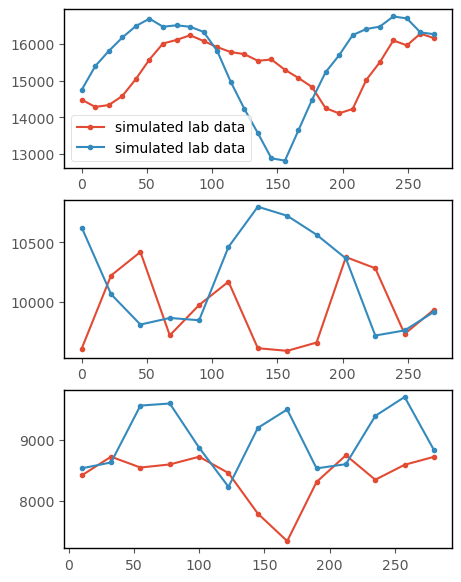

`xtol` termination condition is satisfied.
Function evaluations 13, initial cost 4.3656e+06, final cost 1.2240e+06, first-order optimality 6.24e+00.
Fit parameters:  [4.53994097e+11 1.98582787e+11 1.89218886e+11 7.63183364e+11
 2.58960160e+11 3.17197013e+11 2.54634787e+00 2.83855693e+01]
Standard deviation:  [[ 6.33314655e+14  2.34842063e+14  1.56524618e+14 -9.63401776e+13
  -1.08227409e+14 -1.16846192e+14  4.69602447e+03 -3.81931843e+03]
 [ 2.34842063e+14  2.74079673e+15 -1.86578059e+14 -9.76019117e+13
  -1.09263530e+12 -3.13079507e+14  1.00081297e+05  8.44370921e+02]
 [ 1.56524618e+14 -1.86578059e+14  6.11019981e+14 -3.07521669e+13
  -8.98222935e+13  1.65944847e+13 -3.41314818e+04 -8.29813407e+03]
 [-9.63401776e+13 -9.76019117e+13 -3.07521669e+13  7.49297701e+14
  -1.21886667e+14  6.17175327e+13  3.35782418e+03  5.50428174e+00]
 [-1.08227409e+14 -1.09263530e+12 -8.98222935e+13 -1.21886667e+14
   1.82911820e+14 -7.44381086e+13 -1.31449312e+04 -2.74029052e+03]
 [-1.16846192e+14 -3.1307

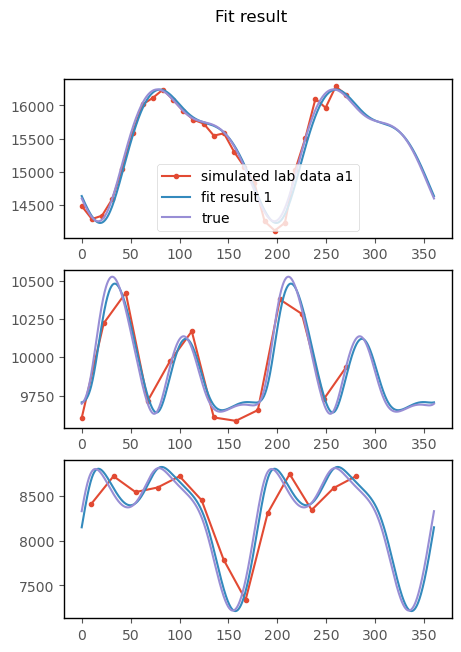

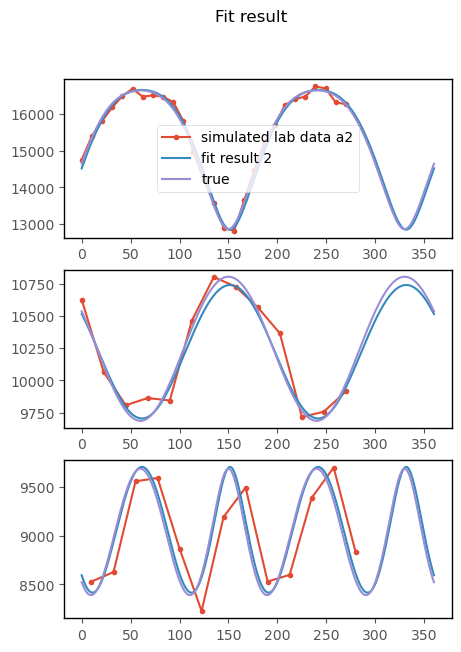

[2.51657437e+07 5.23526191e+07 2.47188184e+07 2.73733027e+07
 1.35244897e+07 2.24733913e+07 5.93718593e-03 3.77409372e-03]


In [54]:
hkl_norm1 = np.array([1,2,1])
offset_true1 = 5
unit_cell_params = [4.1801, 4.1801, 2.6678, 90, 90, 90]
rho = 2.75e3

angles_vps1, vps1, _, _ = generate_sparse_test_data(mineral_type = anisotropy.TetragonalMaterial,
                                                Cijs = stishovite_stiffness,
                                                offset = offset_true1,
                                                start_angle = 0,
                                                end_angle = 270,
                                                hkl_norm = hkl_norm1,
                                                unit_cell_params = unit_cell_params,
                                                rho = rho,
                                                n_data = 27,
                                                noise_mean = 0,
                                                noise_sigma =1e2)

angles_vs1s1, _, vs1s1, _ = generate_sparse_test_data(mineral_type = anisotropy.TetragonalMaterial,
                                                Cijs = stishovite_stiffness,
                                                offset = offset_true1,
                                                start_angle = 0.,
                                                end_angle = 270,
                                                hkl_norm = hkl_norm1,
                                                unit_cell_params = unit_cell_params,
                                                rho = rho,
                                                n_data = 13,
                                                noise_mean = 0,
                                                noise_sigma =1e2)

angles_vs2s1, _, _, vs2s1 = generate_sparse_test_data(mineral_type = anisotropy.TetragonalMaterial,
                                                Cijs = stishovite_stiffness,
                                                offset = offset_true1,
                                                start_angle = 10,
                                                end_angle = 280,
                                                hkl_norm = hkl_norm,
                                                unit_cell_params = unit_cell_params,
                                                rho = rho,
                                                n_data = 13,
                                                noise_mean = 0,
                                                noise_sigma =1e2)

hkl_norm2 = np.array([1,0,0])
offset_true2 = 30
unit_cell_params = [4.1801, 4.1801, 2.6678, 90, 90, 90]
rho = 2.75e3

angles_vps2, vps2, _, _ = generate_sparse_test_data(mineral_type = anisotropy.TetragonalMaterial,
                                                Cijs = stishovite_stiffness,
                                                offset = offset_true2,
                                                start_angle = 0,
                                                end_angle = 270,
                                                hkl_norm = hkl_norm2,
                                                unit_cell_params = unit_cell_params,
                                                rho = rho,
                                                n_data = 27,
                                                noise_mean = 0,
                                                noise_sigma =1e2)

angles_vs1s2, _, vs1s2, _ = generate_sparse_test_data(mineral_type = anisotropy.TetragonalMaterial,
                                                Cijs = stishovite_stiffness,
                                                offset = offset_true2,
                                                start_angle = 0.,
                                                end_angle = 270,
                                                hkl_norm = hkl_norm2,
                                                unit_cell_params = unit_cell_params,
                                                rho = rho,
                                                n_data = 13,
                                                noise_mean = 0,
                                                noise_sigma =1e2)

angles_vs2s2, _, _, vs2s2 = generate_sparse_test_data(mineral_type = anisotropy.TetragonalMaterial,
                                                Cijs = stishovite_stiffness,
                                                offset = offset_true2,
                                                start_angle = 10,
                                                end_angle = 280,
                                                hkl_norm = hkl_norm2,
                                                unit_cell_params = unit_cell_params,
                                                rho = rho,
                                                n_data = 13,
                                                noise_mean = 0,
                                                noise_sigma =1e2)

print(angles_vs1s)
print(angles_vs2s)

fig, ax = plt.subplots(3, 1, figsize = (5,7))
ax[0].plot(angles_vps1, vps1, '.-', label = "simulated lab data")
ax[1].plot(angles_vs1s1, vs1s1, '.-')
ax[2].plot(angles_vs2s1, vs2s1, '.-')
ax[0].plot(angles_vps1, vps2, '.-', label = "simulated lab data")
ax[1].plot(angles_vs1s1, vs1s2, '.-')
ax[2].plot(angles_vs2s1, vs2s2, '.-')
ax[0].legend()
plt.show()



Cij_0 = stishovite_stiffness * np.random.uniform(0.8, 1.2, stishovite_stiffness.shape)



fit_result, err = fit_Cij_lsq(x_vps = [angles_vps1,angles_vps2],
                                        vps = [vps1, vps2],
                                        x_vs1s= [angles_vs1s1,angles_vs1s2],
                                        vs1s = [vs1s1,vs1s2],
                                        x_vs2s = [angles_vs2s1,angles_vs2s2],
                                        vs2s = [vs2s1,vs2s2],
                                        theta_0 = np.append(Cij_0, [5.0, 30.0]),
                                        mineral_type = anisotropy.TetragonalMaterial,
                                        rho = rho,
                                        hkl_norm=[hkl_norm1,hkl_norm2],
                                        unit_cell_params=unit_cell_params
                                        )

Cij_fit = fit_result[:-2]

angles_fit1, vps_fit1, vs1s_fit1, vs2s_fit1 = generate_sparse_test_data(mineral_type = anisotropy.TetragonalMaterial,
                                                                    Cijs = Cij_fit,
                                                                    offset = fit_result[-2],
                                                                    start_angle = 0.,
                                                                    end_angle = 360,
                                                                    hkl_norm = hkl_norm1,
                                                                    unit_cell_params = unit_cell_params,
                                                                    rho = rho,
                                                                    n_data = 1000,
                                                                    noise_mean = 0,
                                                                    noise_sigma = 0)

angles_fit2, vps_fit2, vs1s_fit2, vs2s_fit2 = generate_sparse_test_data(mineral_type = anisotropy.TetragonalMaterial,
                                                                    Cijs = Cij_fit,
                                                                    offset = fit_result[-1],
                                                                    start_angle = 0.,
                                                                    end_angle = 360,
                                                                    hkl_norm = hkl_norm2,
                                                                    unit_cell_params = unit_cell_params,
                                                                    rho = rho,
                                                                    n_data = 1000,
                                                                    noise_mean = 0,
                                                                    noise_sigma = 0)


angles_true1, vps_true1, vs1s_true1, vs2s_true1 = generate_sparse_test_data(mineral_type = anisotropy.TetragonalMaterial,
                                                Cijs = stishovite_stiffness,
                                                offset = offset_true1,
                                                start_angle = 0.,
                                                end_angle = 360,
                                                hkl_norm = hkl_norm1,
                                                unit_cell_params = unit_cell_params,
                                                rho = rho,
                                                n_data = 1000,
                                                noise_mean = 0,
                                                noise_sigma = 0)

angles_true2, vps_true2, vs1s_true2, vs2s_true2 = generate_sparse_test_data(mineral_type = anisotropy.TetragonalMaterial,
                                                Cijs = stishovite_stiffness,
                                                offset = offset_true2,
                                                start_angle = 0.,
                                                end_angle = 360,
                                                hkl_norm = hkl_norm2,
                                                unit_cell_params = unit_cell_params,
                                                rho = rho,
                                                n_data = 1000,
                                                noise_mean = 0,
                                                noise_sigma = 0)



fig, ax = plt.subplots(3, 1, figsize = (5,7))
ax[0].plot(angles_vps1, vps1, '.-', label = "simulated lab data a1")
ax[1].plot(angles_vs1s1, vs1s1, '.-')
ax[2].plot(angles_vs2s1, vs2s1, '.-')


ax[0].plot(angles_fit1, vps_fit1, '-', label = "fit result 1")
ax[1].plot(angles_fit1, vs1s_fit1, '-')
ax[2].plot(angles_fit1, vs2s_fit1, '-')


ax[0].plot(angles_true1, vps_true1, '-', label = "true")
ax[1].plot(angles_true1, vs1s_true1, '-')
ax[2].plot(angles_true1, vs2s_true1, '-')

plt.suptitle("Fit result")
ax[0].legend()
plt.show()


fig, ax = plt.subplots(3, 1, figsize = (5,7))

ax[0].plot(angles_vps2, vps2, '.-', label = "simulated lab data a2")
ax[1].plot(angles_vs1s2, vs1s2, '.-')
ax[2].plot(angles_vs2s2, vs2s2, '.-')

ax[0].plot(angles_fit2, vps_fit2, '-', label = "fit result 2")
ax[1].plot(angles_fit2, vs1s_fit2, '-')
ax[2].plot(angles_fit2, vs2s_fit2, '-')

ax[0].plot(angles_true2, vps_true2, '-', label = "true")
ax[1].plot(angles_true2, vs1s_true2, '-')
ax[2].plot(angles_true2, vs2s_true2, '-')

plt.suptitle("Fit result")
ax[0].legend()
plt.show()


print(err)

In [ ]:
print(fit_result)

[ 5.26603869e+11  2.22970753e+11  2.35386610e+11  7.12767181e+11
  2.43888929e+11  2.87606318e+11  9.67999341e-01 -1.47288233e+01]


In [ ]:
stishovite_stiffness

array([4.55e+11, 1.99e+11, 1.92e+11, 7.62e+11, 2.58e+11, 3.21e+11])